# Approach 1: All pixels


Import libraries:

In [ ]:
import cv2
import numpy as np
import os
import zipfile
from google.colab.patches import cv2_imshow
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip the files:

In [ ]:
path = '/content/drive/MyDrive/Coding/NeuralNetworks4Classification/homer_bart_1.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

Sorts the images in the directory alphabetically and prepends the directory path to get the complete path for each image:

In [ ]:
directory = '/content/homer_bart_1'
files = [os.path.join(directory,f) for f in sorted(os.listdir(directory))]

In [ ]:
height, width = 128, 128

In [ ]:
images = []
classes = []

Preprocess the images:

In [ ]:
for image_path in files:
  try:
    image = cv2.imread(image_path)
    image.shape[:2]
  except:
    continue
  # resize and transform to grayscale
  image = cv2.resize(image, (width, height))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  cv2_imshow(image)

  # flatten into 1d array
  image = image.ravel()

  # append to training input
  images.append(image)

  # create labels
  image_name = os.path.basename(os.path.normpath(image_path))
  if image_name.startswith('b'):
    class_name = 0
  else:
    class_name = 1

  # append to training label
  classes.append(class_name)

Convert X and y to numpy array:


In [ ]:
X = np.asarray(images)
y = np.asarray(classes)

Normalize the data:


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Split train and test sets:

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((215, 16384), (215,), (54, 16384), (54,))

Building the neural network:

In [ ]:
network = tf.keras.Sequential()

In [ ]:
network.add(tf.keras.layers.Dense(input_shape = (16384,), units = 8193, activation = 'relu'))
network.add(tf.keras.layers.Dense(units = 8193, activation = 'relu'))
network.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
#network.build()

In [ ]:
network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8193)              134242305 
                                                                 
 dense_1 (Dense)             (None, 8193)              67133442  
                                                                 
 dense_2 (Dense)             (None, 1)                 8194      
                                                                 
Total params: 201,383,941
Trainable params: 201,383,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
network.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = network.fit(X_train, y_train, epochs = 50)

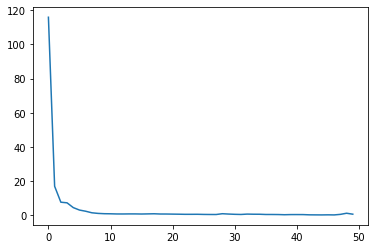

In [ ]:
plt.plot(history.history['loss'])

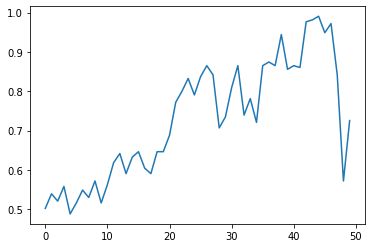

In [ ]:
plt.plot(history.history['accuracy'])

In [ ]:
X_test.shape

(54, 16384)

In [ ]:
predictions = network.predict(X_test)
predictions

In [ ]:
predictions = (predictions > 0.5)

In [ ]:
predictions

In [ ]:
y_test

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.5740740740740741

#How to save the network:

In [ ]:
model_json = network.to_json()
with open('network.json', 'w') as json_file:
  json_file.write(model_json)

NameError: ignored

In [ ]:
from keras.models import save_model
network_saved = save_model(network, 'weights.hdf5')

#How to load the network:

In [ ]:
with open('network.json') as json_file:
  json_saved_model = json_file.read()

In [ ]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('/content/weights.hdf5')
network_loaded.compile(loss = 'binary_crossentropy', optimizer= 'Adam', metrics = ['accuracy'])

In [ ]:
network_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8193)              134242305 
                                                                 
 dense_1 (Dense)             (None, 8193)              67133442  
                                                                 
 dense_2 (Dense)             (None, 1)                 8194      
                                                                 
Total params: 201,383,941
Trainable params: 201,383,941
Non-trainable params: 0
_________________________________________________________________


Classifying images:

In [ ]:
test_img = X_test[0]
test_img = scaler.inverse_transform(test_img.reshape(1, -1))

In [ ]:
network_loaded.predict(test_img)

array([[0.]], dtype=float32)

# Approach 2: Feature Extraction:

In [ ]:
files = [os.path.join(directory,f) for f in sorted(os.listdir(directory))]

Define headers for features data:

In [ ]:
export = 'CHIN, PANTS, SHOES, TSHIRT, SHORT, SNEAKERS, CLASS\n'

In [ ]:
features = []
show_images = False

In [ ]:
for image_path in files:
  try:
    original_image = cv2.imread(image_path)
    (H,W) = original_image.shape[:2]
  except:
    continue

  image = original_image.copy()
  image_features = []

  CHIN = PANTS = SHOES = 0
  TSHIRT = SHORTS = SNEAKERS = 0

  image_name = os.path.basename(os.path.normpath(image_path))

  if(image_name.startswith('b')):
    class_name = 0
  else:
    class_name = 1

  for height in range(0,H):
    for width in range (0,W):
      blue = image.item(height, width, 0)
      green = image.item(height, width, 1)
      red = image.item(height, width, 2)

      # Homer's chin color - brown:
      if (blue >= 95 and blue <= 140 and green >= 160 and green <= 185 and red >= 175 and red <= 200):
        image[height, width] = (255, 255, 0)
        CHIN += 1

      # Homer's pants color - blue:
      if (blue >= 150 and blue <= 180 and green >= 98 and green <= 120 and red >= 0 and red <= 90):
        image[height, width] = [0, 255, 255]
        PANTS += 1
      
      # Homer's shoes - gray
      # Usually the shoes are in the bottom half of the picture
      if height > (H / 2):
        if (blue >= 25 and blue <= 45 and green >= 25 and green <= 45 and red >= 25 and red <= 45):
          image[height, width] = [0, 255, 255]
          SHOES += 1


      # Bart's t-shirt - orange:
      if (blue >= 11 and blue <= 22 and green >= 85 and green <= 105 and red >= 240 and red <= 255):
        image[height, width] = [0, 255, 128]
        TSHIRT += 1

      # Bart - blue shorts
      if (blue >= 125 and blue <= 170 and green >= 0 and green <= 12 and red >= 0 and red <= 20):
        image[height, width] = [0, 255, 128]
        SHORTS += 1

      # Bart - blue sneakers
      if height > (H / 2):
        if (blue >= 125 and blue <= 170 and green >= 0 and green <= 12 and red >= 0 and red <= 20):
          image[height, width] = [0, 255, 128]
          SNEAKERS += 1

      


  # The images have different sizes, so use percentage
  CHIN = round((CHIN / (H * W)) * 100, 9)
  PANTS = round((PANTS / (H * W)) * 100, 9)
  SHOES = round((SHOES / (H * W)) * 100, 9)

  TSHIRT = round((TSHIRT / (H * W)) * 100, 9)
  SHORTS = round((SHORTS / (H * W)) * 100, 9)
  SNEAKERS = round((SNEAKERS / (H * W)) * 100, 9)


  image_features.append(CHIN)
  image_features.append(PANTS)
  image_features.append(SHOES)
  image_features.append(TSHIRT)
  image_features.append(SHORTS)
  image_features.append(SNEAKERS)
  image_features.append(class_name)

  features.append(image_features)

  if show_images == True:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
      fig, im = plt.subplots(1,2)
      im[0].axis('off')
      im[0].imshow(original_image)
      im[1].axis('off')
      im[1].imshow(image)
      plt.show()
  
  print('Homer chin: %s - Homer pants %s - Homer shoes %s ' % (image_features[0], image_features[1], image_features[2]))
  print('Bart t-shirt: %s - Bart shorts: %s - Bart sneakers: %s ' % (image_features[3], image_features[4], image_features[5]))

  # Convert the list of image_features to string
  f = (",".join([str(item) for item in image_features]))
  export += f + '\n'

Homer chin: 0.0 - Homer pants 0.0 - Homer shoes 0.114799225 
Bart t-shirt: 6.886101887 - Bart shorts: 3.495204355 - Bart sneakers: 3.495204355 
Homer chin: 0.0 - Homer pants 0.0 - Homer shoes 0.11007847 
Bart t-shirt: 5.004901113 - Bart shorts: 3.183888705 - Bart sneakers: 3.183888705 
Homer chin: 0.0 - Homer pants 0.0 - Homer shoes 0.182518631 
Bart t-shirt: 5.264620437 - Bart shorts: 5.029682961 - Bart sneakers: 5.029682961 
Homer chin: 0.0 - Homer pants 0.480168257 - Homer shoes 0.080028043 
Bart t-shirt: 0.0 - Bart shorts: 0.0 - Bart sneakers: 0.0 
Homer chin: 0.0 - Homer pants 0.0 - Homer shoes 0.029707562 
Bart t-shirt: 8.978929368 - Bart shorts: 3.459119497 - Bart sneakers: 3.459119497 
Homer chin: 0.0 - Homer pants 0.0 - Homer shoes 0.053304904 
Bart t-shirt: 6.75432362 - Bart shorts: 0.948827292 - Bart sneakers: 0.948827292 
Homer chin: 0.249585206 - Homer pants 0.0 - Homer shoes 0.019853369 
Bart t-shirt: 9.693407263 - Bart shorts: 4.104683977 - Bart sneakers: 4.104683977 
Ho

In [ ]:
image_features

[0.853902001, 13.744247745, 0.161778023, 0.0, 0.0, 0.0, 1]

In [ ]:
export

'CHIN, PANTS, SHOES, TSHIRT, SHORT, SNEAKERS, CLASS\n0.0,0.0,0.114799225,6.886101887,3.495204355,3.495204355,0\n0.0,0.0,0.11007847,5.004901113,3.183888705,3.183888705,0\n0.0,0.0,0.182518631,5.264620437,5.029682961,5.029682961,0\n0.0,0.480168257,0.080028043,0.0,0.0,0.0,0\n0.0,0.0,0.029707562,8.978929368,3.459119497,3.459119497,0\n0.0,0.0,0.053304904,6.75432362,0.948827292,0.948827292,0\n0.249585206,0.0,0.019853369,9.693407263,4.104683977,4.104683977,0\n0.0,0.0,0.181208054,0.0,0.0,0.0,0\n0.0,0.0,0.148868778,0.0,0.0,0.0,0\n0.0,0.0,0.114762211,9.594752524,7.522715548,7.522715548,0\n0.0,0.0,0.138655462,0.0,0.0,0.0,0\n0.0,0.0,0.02400947,19.545383481,0.0,0.0,0\n0.00307645,0.0,0.0,6.495154592,5.599138594,5.599138594,0\n0.001317263,0.0,0.087817515,0.0,0.0,0.0,0\n0.0,0.0,0.032184591,8.395721925,0.0,0.0,0\n0.02105732,0.0,0.008503918,8.915750471,0.0,0.0,0\n0.0,0.0,0.081055114,11.095816228,4.525111363,4.525111363,0\n0.0,0.0,0.08757526,10.443349754,3.183296307,3.183296307,0\n0.0,0.0,0.043806812,9.49

In [ ]:
with open('features.csv', 'w') as file:
  for l in export:
    file.write(l)
file.close

<function TextIOWrapper.close>

In [ ]:
dataset = pd.read_csv('features.csv')
dataset

,CHIN,PANTS,SHOES,TSHIRT,SHORT,SNEAKERS,CLASS
0,0.000000,0.000000,0.114799,6.886102,3.495204,3.495204,0
1,0.000000,0.000000,0.110078,5.004901,3.183889,3.183889,0
2,0.000000,0.000000,0.182519,5.264620,5.029683,5.029683,0
3,0.000000,0.480168,0.080028,0.000000,0.000000,0.000000,0
4,0.000000,0.000000,0.029708,8.978929,3.459119,3.459119,0
...,...,...,...,...,...,...,...
264,6.485412,0.000000,0.171985,0.000000,0.000000,0.000000,1
265,0.000000,0.000000,0.161637,0.000000,0.000000,0.000000,1
266,4.264975,0.000000,0.329940,0.000000,0.000000,0.000000,1
267,1.429133,0.000000,0.034559,0.000000,0.000000,0.000000,1


In [ ]:
X = dataset.iloc[:, 0:6].values
y = dataset.iloc[:, 6].values

Split training and test sets:


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

Building and training the neural network:

In [ ]:
network2 = tf.keras.Sequential()
network2.add(tf.keras.layers.Dense(input_shape = (6,), units = 4, activation='relu'))
network2.add(tf.keras.layers.Dense(units = 4, activation='relu'))
network2.add(tf.keras.layers.Dense(units = 4, activation='relu'))
# Sigmoid because we have a binary classification
network2.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))

In [ ]:
network2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 28        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


In [ ]:
network2.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = network2.fit(X_train, y_train, epochs = 50)

Epoch 1/50
7/7 [==============================] - 2s 4ms/step - loss: 0.9550 - accuracy: 0.6326
Epoch 2/50
7/7 [==============================] - 0s 3ms/step - loss: 0.9298 - accuracy: 0.6186
Epoch 3/50
7/7 [==============================] - 0s 4ms/step - loss: 0.9083 - accuracy: 0.6233
Epoch 4/50
7/7 [==============================] - 0s 5ms/step - loss: 0.8857 - accuracy: 0.6233
Epoch 5/50
7/7 [==============================] - 0s 3ms/step - loss: 0.8685 - accuracy: 0.6186
Epoch 6/50
7/7 [==============================] - 0s 3ms/step - loss: 0.8506 - accuracy: 0.6140
Epoch 7/50
7/7 [==============================] - 0s 5ms/step - loss: 0.8321 - accuracy: 0.6140
Epoch 8/50
7/7 [==============================] - 0s 3ms/step - loss: 0.8165 - accuracy: 0.6140
Epoch 9/50
7/7 [==============================] - 0s 7ms/step - loss: 0.8010 - accuracy: 0.6093
Epoch 10/50
7/7 [==============================] - 0s 3ms/step - loss: 0.7879 - accuracy: 0.6093
Epoch 11/50
7/7 [======================

Evaluate the network:

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

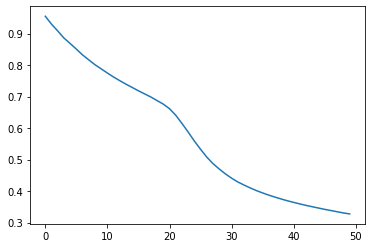

In [ ]:
plt.plot(history.history['loss']);

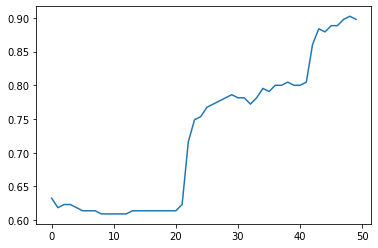

In [ ]:
plt.plot(history.history['accuracy']);

In [ ]:
predictions = network2.predict(X_test)

In [ ]:
predictions = (predictions > 0.5)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.9074074074074074

Confusion matrix:

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
cm

array([[26,  2],
       [ 3, 23]])

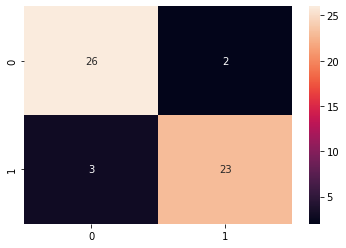

In [ ]:
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91        28
           1       0.92      0.88      0.90        26

    accuracy                           0.91        54
   macro avg       0.91      0.91      0.91        54
weighted avg       0.91      0.91      0.91        54



Save the model:

In [ ]:
model_json = network2.to_json()
with open('network2.json', 'w') as json_file:
  json_file.write(model_json)

In [ ]:
from keras.models import save_model
network2_saved = save_model(network2, 'weights.hdf5')

In [ ]:
with open('network2.json') as json_file:
  json_saved_model = json_file.read()

In [ ]:
network2_loaded = tf.keras.models.model_from_json(json_saved_model)
network2_loaded.load_weights('/content/weights.hdf5')
network2_loaded.compile(loss = 'binary_crossentropy', optimizer= 'Adam', metrics = ['accuracy'])

In [ ]:
network2_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 28        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_image = X_test[33]
test_image

array([0.        , 0.15504173, 0.140367  , 0.        , 0.        ,
       0.        ])

Batch format:

In [ ]:
test_image = test_image.reshape(1, -1)
test_image.shape

(1, 6)

In [ ]:
network2_loaded.predict(test_image)

array([[0.48087323]], dtype=float32)

In [ ]:
network2_loaded.predict(test_image)[0][0]

0.48087323

In [ ]:
if(network_loaded.predict(test_image))[0][0] < 0.5:
  print('Bart')
else:
  print('Homer')